# Week 12 Lab: RecSys

As of 26 March 2025, Google Colab update numpy to 2.0.2. Thus, we unfortunately need to downgrade numpy version for dependencies compatability.

In [1]:
# !pip install numpy==1.26.4

After installing 1.26.4, you need to "Restart Session" and re-import numpy

In [2]:
import numpy as np
print(np.__version__)
print(np.__file__)

1.26.4
/usr/local/lib/python3.11/dist-packages/numpy/__init__.py


## Section 1: Build a simple recommender system from scratch

#### We will use the Movielens 10 million dataset (https://grouplens.org/datasets/movielens/10m/)

In [3]:
import os
import zipfile
from urllib.request import urlretrieve

In [4]:
# If file exists, skip the download
data_file_path = "movielens/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

In [5]:
# unzip and read the ratings.dat file
dataFile = zipfile.ZipFile(data_file_path + "movielens_10m.zip")

mv_path = dataFile.extract("ml-10M100K/ratings.dat", path = data_file_path)

#### Let's take a look at the data

In [6]:
import pandas as pd

In [7]:
mv_df = pd.read_csv(filepath_or_buffer=mv_path, sep="::", header=None, dtype={0:int, 1:int, 2:float, 3:int}, engine='python')

mv_df.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

In [8]:
mv_df.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


In [9]:
print("The number of interactions is {}".format(len(mv_df)))

The number of interactions is 10000054


#### We will now create a sparse matrix

##### <u>Note</u> : we read UserID and ItemID as int, but this is not always the case if the IDs are alphanumeric

#### Let's extract the list of unique user id and item id, and show some statistics to understand our data

In [10]:
userID_unique = mv_df["UserID"].unique()
itemID_unique = mv_df["ItemID"].unique()

In [11]:
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(mv_df)

print("Number of users: {}\t, Number of items: {}".format(n_users, n_items))
print("Max UserID: {}\t, Max ItemID: {}".format(max(userID_unique), max(itemID_unique)))

Number of users: 69878	, Number of items: 10677
Max UserID: 71567	, Max ItemID: 65133


#### We observe that the max ID of users and items is higher than the number of unique users and items. Thus, we have some empty profiles

#### We should remove those empty indices, by creating a new mapping

In [12]:
mapped_id, original_id = pd.factorize(mv_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(mv_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

In [13]:
user_original_ID_to_index

,0
1,0
2,1
3,2
4,3
5,4
...,...
71563,69873
71564,69874
71565,69875
71566,69876


In [14]:
item_original_ID_to_index

,0
122,0
185,1
231,2
292,3
316,4
...,...
7537,10672
63481,10673
64652,10674
64427,10675


In [15]:
original_item_ID = 292
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))

New index for item 292 is 3


#### Replacing the IDs in the dataframe and we are ready to use the data

In [16]:
mv_df["UserID"] = mv_df["UserID"].map(user_original_ID_to_index)
mv_df["ItemID"] = mv_df["ItemID"].map(item_original_ID_to_index)

In [17]:
mv_df.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [18]:
userID_unique = mv_df["UserID"].unique()
itemID_unique = mv_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(mv_df)

print("Number of users: {}\t, Number of items: {}".format(n_users, n_items))
print("Max UserID: {}\t, Max ItemID: {}\n".format(max(userID_unique), max(itemID_unique)))

print("Average interactions per user: {:.2f}".format(n_interactions/n_users))
print("Average interactions per item: {:.2f}\n".format(n_interactions/n_items))

print("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_users*n_items))*100))

Number of users: 69878	, Number of items: 10677
Max UserID: 69877	, Max ItemID: 10676

Average interactions per user: 143.11
Average interactions per item: 936.60

Sparsity 98.66 %


#### Rating distribution in time

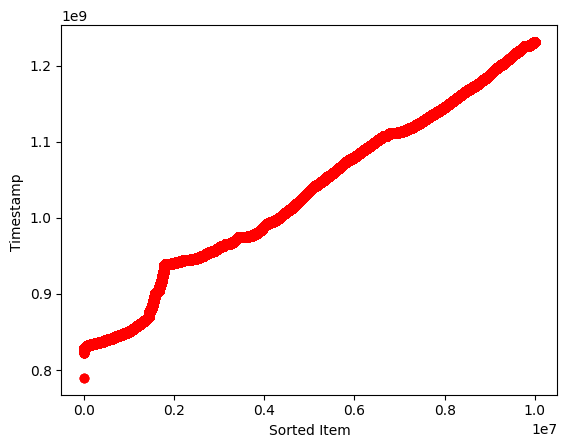

In [19]:
import matplotlib.pyplot as pyplot

# Clone the list to avoid changing the ordering of the original data
timestamp_sorted = mv_df["Timestamp"].values.copy()
timestamp_sorted.sort()

pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp ')
pyplot.xlabel('Sorted Item')
pyplot.show()

#### We use a sparse matrix to store the data. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [20]:
import scipy.sparse as sps

mv_all = sps.coo_matrix((mv_df["Interaction"].values, (mv_df["UserID"].values, mv_df["ItemID"].values)))

mv_all

<COOrdinate sparse matrix of dtype 'float64'
	with 10000054 stored elements and shape (69878, 10677)>

In [21]:
mv_all.tocsr()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10000054 stored elements and shape (69878, 10677)>

#### We compute the item popularity as the number of interaction in each column

#### We can use the properties of sparse matrices in CSC format

In [22]:
import numpy as np

item_popularity = np.ediff1d(mv_all.tocsc().indptr)
item_popularity

array([ 2412, 14975, 17851, ...,     1,     1,     1], dtype=int32)

In [23]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    1,     1,     1, ..., 33668, 34457, 34864], dtype=int32)

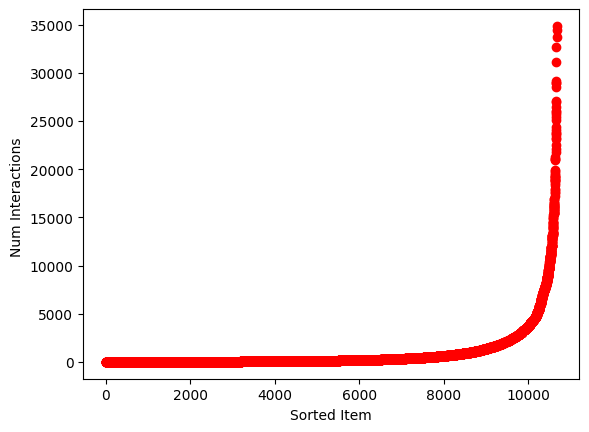

In [24]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [25]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset: {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items: {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items: {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items: {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset: 936.60
Average per-item interactions for the top 10% popular items: 6479.52
Average per-item interactions for the least 10% popular items: 5.23
Average per-item interactions for the median 10% popular items: 136.45


In [26]:
print("Number of items with zero interactions {}".format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


#### We compute the user activity (profile length) as the number of interaction in each row

#### We can use the properties of sparse matrices in CSR format

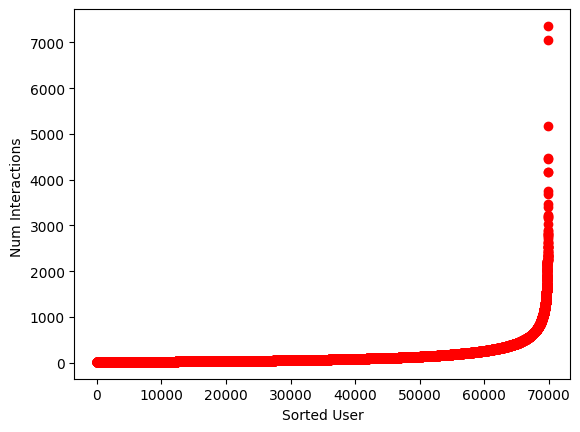

In [27]:
user_activity = np.ediff1d(mv_all.tocsr().indptr)
user_activity = np.sort(user_activity)

pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

#### Evaluation:
In order to evaluate our recommender, we have to:
* Split the data into mv_train and mv_test (i.e., train and test set)
* Define evaluation metrics
* Define a functon to compute the evaluation for each user

##### <u>Note</u>: The splitting of the data is very important to ensure your algorithm is evaluated appropriately

In [28]:
train_test_split = 0.80

n_interactions = mv_all.nnz


train_mask = np.random.choice([True, False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True, False, False, ...,  True,  True,  True])

In [29]:
mv_train = sps.csr_matrix((mv_all.data[train_mask], (mv_all.row[train_mask], mv_all.col[train_mask])))

mv_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7999845 stored elements and shape (69878, 10677)>

In [30]:
test_mask = np.logical_not(train_mask)

mv_test = sps.csr_matrix((mv_all.data[test_mask], (mv_all.row[test_mask], mv_all.col[test_mask])))

mv_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2000209 stored elements and shape (69878, 10669)>

#### We call items in the test set 'relevant'

In [31]:
user_id = 124
relevant_items = mv_test[user_id].indices
relevant_items

array([   4,    5,   29,   37,   71,   85,   94,  144,  146,  179,  181,
        183,  220,  225,  227,  231,  238,  336,  340,  360,  373,  401,
        408, 1280, 1302, 1314, 1318, 1321, 1464, 1469, 1496], dtype=int32)

#### Assume that we have a recommendation list such as:

In [32]:
recommended_items = np.array([241, 1622, 15, 857, 5823])
recommended_items

array([ 241, 1622,   15,  857, 5823])

In [33]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

#### Precision: how many of the recommended items are relevant

In [34]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

#### Recall: how many of the relevant items I was able to recommend

In [35]:
def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

#### Average Precision

In [36]:
def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

#### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

#### Let's start with a random recommender

#### In a random recommender, we don't learn anything from the data

In [37]:
class RandomRecommender(object):

    def fit(self, mv_train):

        self.n_items = mv_train.shape[1]


    def recommend(self, user_id, at=5):

        recommended_items = np.random.choice(self.n_items, at)

        return recommended_items

#### (Optional) Homework: Improve RandomRecommender such as the recommended list doesn't contain item 235 (because this item is not good to recommend to the users)

In [38]:
randomRecommender = RandomRecommender()
randomRecommender.fit(mv_train)

for user_id in range(10):
    print(randomRecommender.recommend(user_id, at=5))

[2952  301 7536 2183 4762]
[ 8969  7262  8987 10568  4628]
[8298 1463 7512 1575 6249]
[5795 5280 9173 2291 9609]
[4325 5916 1817 5179 4892]
[ 887 7973  410 3683 3838]
[8347 8429 8417  252 1401]
[9003 9845  735 3794  202]
[8913 6625 7431 1709 2267]
[2642 9356 9580  575 1178]


#### Put all together in an evaluation function and let's test it!

In [39]:
# We pass as paramether the recommender class

def evaluate_algorithm(mv_test, recommender_object, at=5):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(mv_test.shape[0]):

        relevant_items = mv_test.indices[mv_test.indptr[user_id]:mv_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval += 1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP))


In [40]:
evaluate_algorithm(mv_test, randomRecommender)

Recommender results are: Precision = 0.0027, Recall = 0.0005, MAP = 0.0013


#### Yay! We have our first recommender. The recommendation quality however...

#### Top Popular (TopPop) recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions

#### In this case our model is the item popularity

In [41]:
class TopPopRecommender(object):

  def fit(self, mv_train):

      item_popularity = np.ediff1d(mv_train.tocsc().indptr)

      # We are not interested in sorting the popularity value,
      # but to order the items according to it
      self.popular_items = np.argsort(item_popularity)
      self.popular_items = np.flip(self.popular_items, axis=0)

  def recommend(self, user_id, at=5):

      recommended_items = self.popular_items[0:at]

      return recommended_items

#### Now train and test our model

In [42]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(mv_train)

In [43]:
for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=5))

[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]


In [44]:
evaluate_algorithm(mv_test, topPopRecommender, at=5)

Recommender results are: Precision = 0.0957, Recall = 0.0308, MAP = 0.0527


#### That's better! But we can still improve

##### <u>Hint</u>: remove items already seen by the user. We can either remove them from the recommended item list or we can set them to a score so low that it will cause them to end at the very bottom of all the available items

In [45]:
class TopPopRecommender(object):

    def fit(self, mv_train):

        self.mv_train = mv_train

        item_popularity = np.ediff1d(mv_train.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis=0)


    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.mv_train.indices[self.mv_train.indptr[user_id]:self.mv_train.indptr[user_id+1]]

            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert=True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]


        return recommended_items

In [46]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(mv_train)

for user_id in range(10):
    print(topPopRecommender_removeSeen.recommend(user_id, at=5))

[1008  139 1293  175   22]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7   14 1293  175]
[1008    7  139   14 1293]
[1008    7   14 1293  175]
[1008    7  139 1293   22]
[1008    7  139   14 1293]
[  14 1293   19   22   24]


In [47]:
evaluate_algorithm(mv_test, topPopRecommender_removeSeen)

Recommender results are: Precision = 0.1980, Recall = 0.0527, MAP = 0.1475


#### Simple but effective. Always remove seen items if your purpose is to recommend "new" ones

## Secion 2: User-based Collaborative Filtering

In this section, we will walk through another movie rating example for user-based collaborative filtering

#### We first read the data, which contains ratings from different critics on various titles

In [49]:
rating = pd.read_csv('/content/sample_data/movie_rating.csv')
rating.head()

,critic,title,rating
0,Jack Matthews,Lady in the Water,3.0
1,Jack Matthews,Snakes on a Plane,4.0
2,Jack Matthews,You Me and Dupree,3.5
3,Jack Matthews,Superman Returns,5.0
4,Jack Matthews,The Night Listener,3.0


#### We will first create the matrix with titles of movies as rows and critics (i.e., users) as columns. Each cell contains the rating from the corresponding user for a rating

In [50]:
rp = rating.pivot_table(index=['title'], columns=['critic'], values='rating')
rp

critic,Claudia Puig,Gene Seymour,Jack Matthews,Lisa Rose,Mick LaSalle,Toby
title,,,,,,
Just My Luck,3.0,1.5,NaN,3.0,2.0,NaN
Lady in the Water,NaN,3.0,3.0,2.5,3.0,NaN
Snakes on a Plane,3.5,3.5,4.0,3.5,4.0,4.5
Superman Returns,4.0,5.0,5.0,3.5,3.0,4.0
The Night Listener,4.5,3.0,3.0,3.0,3.0,NaN
You Me and Dupree,2.5,3.5,3.5,2.5,2.0,1.0


#### The next step is to find the similarity score between the critics. We will use _Toby_ as example, and use _Pearson correlation_ score.

##### <u>Note</u>: Pandas contains the function `corrwith()` which compute the correlation

In [51]:
rating_toby = rp['Toby']
sim_toby = rp.corrwith(rating_toby)
sim_toby

,0
critic,
Claudia Puig,0.893405
Gene Seymour,0.381246
Jack Matthews,0.662849
Lisa Rose,0.991241
Mick LaSalle,0.924473
Toby,1.000000


#### As you can see from the result above, Toby's taste is similar to Lisa Rose but not so much wit Gene Seymour.

#### To make recommendation for Toby, we calculate a rating of others weighted by the similarity. Note that we only need to calculate rating for movies Toby has not yet seen.

In [52]:
# we first filter out irrelevant data, then assign the similarity score and the weighted rating
rating_c = rating.loc[rating_toby[rating.title].isnull().values & (rating.critic != 'Toby')]
rating_c_similarity = rating_c['critic'].map(sim_toby)

rating_c = rating_c.assign(similarity=rating_c_similarity, sim_rating=rating_c_similarity * rating_c.rating)
rating_c.head()

,critic,title,rating,similarity,sim_rating
0,Jack Matthews,Lady in the Water,3.0,0.662849,1.988547
4,Jack Matthews,The Night Listener,3.0,0.662849,1.988547
5,Mick LaSalle,Lady in the Water,3.0,0.924473,2.773420
7,Mick LaSalle,Just My Luck,2.0,0.924473,1.848947
10,Mick LaSalle,The Night Listener,3.0,0.924473,2.773420


#### Lastly, we add up the score for each title using `groupby()`. We also normalize the score by dividing it with the sum of the weights.

#### Base on other critics' similarity and their rating, we have made a movie recommendation for Toby:

In [53]:
recommendations = rating_c.groupby('title').apply(lambda s: s.sim_rating.sum() / s.similarity.sum())
recommendations.sort_index(ascending=False)

<ipython-input-53-eacc77767a66>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommendations = rating_c.groupby('title').apply(lambda s: s.sim_rating.sum() / s.similarity.sum())


,0
title,
The Night Listener,3.347790
Lady in the Water,2.832550
Just My Luck,2.530981


## Secion 3: Item-based Collaborative Filtering

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data: https://surpriselib.com/

In this section, we will walk through another movie rating example for item-based collaborative filtering

#### Dataset: https://grouplens.org/datasets/movielens/100k/

In [54]:
!pip install scikit-surprise

In [55]:
import numpy as np
import pandas as pd
import heapq
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise.model_selection import train_test_split

In [56]:
# If file exists, skip the download
data_100k_file_path = "movielens/Movielens100K/"
data_100k_file_name = data_100k_file_path + "ml-100k.zip"

# If directory does not exist, create
if not os.path.exists(data_100k_file_path):
    os.makedirs(data_100k_file_path)

if not os.path.exists(data_100k_file_name):
    urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", data_100k_file_name)

In [57]:
# unzip and read the u.data file
dataFile = zipfile.ZipFile(data_100k_file_path + "ml-100k.zip")

u_rating_path = dataFile.extract("ml-100k/u.data", path = data_100k_file_path)

In [58]:
columns = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(u_rating_path, sep = '\t', names = columns)

In [59]:
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### Surprise has its own data input handle methods, and we need to use reader to read the dataframe and convert to Surprise trainset.

#### Since we are care doing item-based, care about similarity between items, we change the column order

In [60]:
reader = Reader(rating_scale = (1, 5))
item_based_data = Dataset.load_from_df(data[['item_id', 'user_id', 'rating']], reader)

In [61]:
full_trainset = item_based_data.build_full_trainset()

In [62]:
trainSet, testSet = train_test_split(item_based_data, test_size = 0.2, random_state = 42)

trainSet

#### We will use KNNBasic (https://surprise.readthedocs.io/en/stable/knn_inspired.html) to predict the missing ratings

#### Note that since we have change the column order while we 'convert' the data (i.e., item_based_data above), we need to set 'user_based' to True here.

#### Please read the documentation of KNNBasic in Surprise for better understanding

In [63]:
KNNBasic_fullTrainSet = KNNBasic(k = 40, min_k = 1, random_state = 42)
KNNBasic_fullTrainSet.sim_options = {'name':'pearson', 'user_based':True}

KNNBasic_fullTrainSet.fit(full_trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [64]:
simMatrix_KNNBasic = KNNBasic_fullTrainSet.compute_similarities()

print('KNNBasic similarity matrix shape: ', simMatrix_KNNBasic.shape)

print('\nPrint the first 5 rows and 5 columns of the KNNBasic similarity matrix:')
print(simMatrix_KNNBasic[0:4][0:4])

Computing the pearson similarity matrix...
Done computing similarity matrix.
KNNBasic similarity matrix shape:  (1682, 1682)

Print the first 5 rows and 5 columns of the KNNBasic similarity matrix:
[[1.         0.42799905 0.         ... 0.         0.         0.        ]
 [0.42799905 1.         0.13363062 ... 0.         0.         0.        ]
 [0.         0.13363062 1.         ... 0.         0.         0.        ]
 [0.07430376 0.2994642  0.78107061 ... 0.         0.         0.        ]]


#### Let's find similarity items

In [65]:
# Import the user_id and movie_title mapping data
u_item_path = dataFile.extract("ml-100k/u.item", path = data_100k_file_path)
items = pd.read_csv(u_item_path, sep = '|', header = None, encoding = 'latin-1')
items = items.iloc[:, 0:2]
items.columns = ['item_id', 'movie_title']

In [66]:
print('Print part of the item_id and the corresponding movie_title:')
print(items.iloc[0:9, :])

Print part of the item_id and the corresponding movie_title:
   item_id                                        movie_title
0        1                                   Toy Story (1995)
1        2                                   GoldenEye (1995)
2        3                                  Four Rooms (1995)
3        4                                  Get Shorty (1995)
4        5                                     Copycat (1995)
5        6  Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6        7                              Twelve Monkeys (1995)
7        8                                        Babe (1995)
8        9                            Dead Man Walking (1995)


In [67]:
# Select a movie and later we will recommend movies similar to this
print('\n Select a movie that I like, and find its item_id')
print(items[items['movie_title'].str.contains('Star Wars')])


 Select a movie that I like, and find its item_id
    item_id       movie_title
49       50  Star Wars (1977)


In [68]:
# Similarity of this selected movie and the others
sim_selected = simMatrix_KNNBasic[49]
print('\n Similarities based on the selected movie \n', sim_selected)


 Similarities based on the selected movie 
 [ 0.05365553  0.24856031 -0.875      ...  0.          0.
  0.        ]


In [69]:
# Find the indices of the k most similar items
k = 10
k_sim_idx_heap = []
for i in range(len(sim_selected)):
    if i == 49:
        continue
    if len(k_sim_idx_heap) < k:
        heapq.heappush(k_sim_idx_heap, (sim_selected[i], i))
    else:
        if sim_selected[i] > k_sim_idx_heap[0][0]:
            heapq.heappop(k_sim_idx_heap)
            heapq.heappush(k_sim_idx_heap, (sim_selected[i], i))

print(k_sim_idx_heap)

[(1.0, 343), (1.0, 398), (1.0, 448), (1.0, 626), (1.0, 1085), (1.0, 1153), (1.0, 1160), (1.0, 1135), (1.0, 788), (1.0, 1308)]


In [70]:
# print out the corresponding movie_title
# since it is min heap, when printing we print from the last item to the first item
print('\n The recommemed movies are:')
for i in range(len(k_sim_idx_heap)-1, -1, -1):
    idx = k_sim_idx_heap[i][1]
    print(items.iloc[idx, 1])


 The recommemed movies are:
Very Natural Thing, A (1974)
Swimming with Sharks (1995)
Ghosts of Mississippi (1996)
Palookaville (1996)
Alphaville (1965)
It's My Party (1995)
Robin Hood: Prince of Thieves (1991)
Star Trek: The Motion Picture (1979)
Three Musketeers, The (1993)
Apostle, The (1997)


## Section 4: Building a DL based RS

In [71]:
from surprise import Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle

### We first need to define a data loader

In [72]:
class Loader():
    current = 0

    def __init__(self, x, y, batch_size=2048, is_shuffle=True):
        from sklearn.utils import shuffle
        self.shuffle = shuffle
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.batches = range(0, len(self.y), batch_size)

        # If is_shuffle, we re-shuffle on every epoch
        if is_shuffle:
            self.x, self.y = shuffle(self.x, self.y)

    def __iter__(self):
        # Reset and return a new iterator
        self.x, self.y = shuffle(self.x, self.y, random_state=0)
        self.current = 0
        return self

    def __len__(self):
        # Return the number of batches
        return int(len(self.x) / self.batch_size)

    def __next__(self):
        n = self.batch_size

        if self.current + n >= len(self.y):
            raise StopIteration

        i = self.current
        xs = torch.from_numpy(self.x[i:i + n])
        ys = torch.from_numpy(self.y[i:i + n])

        self.current += n

        return (xs, ys)

### Let us build a Matrix Factorization (MF) model using PyTorch

In [73]:
class MF(nn.Module):

    def __init__(self, n_user, n_item, k=18, c_vector=1.0, c_bias=1.0):
        super(MF, self).__init__()
        self.k = k
        self.n_user = n_user
        self.n_item = n_item
        self.c_bias = c_bias
        self.c_vector = c_vector

        self.user = nn.Embedding(n_user, k)
        self.item = nn.Embedding(n_item, k)

        # We add new terms here:
        self.bias_user = nn.Embedding(n_user, 1)
        self.bias_item = nn.Embedding(n_item, 1)

        self.bias = nn.Parameter(torch.ones(1))

    def forward(self, train_x):
        user_id = train_x[:, 0]
        item_id = train_x[:, 1]

        vector_user = self.user(user_id)
        vector_item = self.item(item_id)

        # Pull out biases
        bias_user = self.bias_user(user_id).squeeze()
        bias_item = self.bias_item(item_id).squeeze()

        biases = self.bias + bias_user + bias_item

        ui_interaction = torch.sum(vector_user * vector_item, dim=1)

        # Add bias prediction to the interaction prediction
        prediction = ui_interaction + biases
        return prediction

    def loss(self, prediction, target):

        def l2_regularize(array):
            loss = torch.sum(array**2)
            return loss

        loss_mse = F.mse_loss(prediction, target.squeeze())

        # Add new regularization to the biases
        prior_bias_user =  l2_regularize(self.bias_user.weight) * self.c_bias
        prior_bias_item = l2_regularize(self.bias_item.weight) * self.c_bias

        prior_user =  l2_regularize(self.user.weight) * self.c_vector
        prior_item = l2_regularize(self.item.weight) * self.c_vector

        total = loss_mse + prior_user + prior_item + prior_bias_user + prior_bias_item
        return total

### Finally, we define the main() function

In [74]:
def main():
    # Get data
    data = Dataset.load_builtin('ml-1m')
    trainset = data.build_full_trainset()
    uir = np.array([x for x in trainset.all_ratings()])

    train_x = test_x = uir[:,:2].astype(np.int64)
    train_y = test_y = uir[:,2].astype(np.float32)

    # Define parameters
    lr = 1e-1 # learning rate
    k = 10  # embedding size or latent dimension
    c_bias = 1e-6
    c_vector = 1e-6
    batch_size = 2048

    model = MF(trainset.n_users, trainset.n_items, k=k, c_bias=c_bias, c_vector=c_vector)

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    dataloader = Loader(train_x, train_y, batch_size=batch_size)

    itr = 0
    for batch in dataloader:

        itr += 1

        prediction = model(batch[0])
        loss = model.loss(prediction,batch[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"iteration: {itr}. training loss: {loss}")

    torch.save(model.state_dict(), "./recommendation_model_pytorch.pkl")

if __name__=='__main__':
    main()

iteration: 1. training loss: 19.223493576049805
iteration: 2. training loss: 17.522212982177734
iteration: 3. training loss: 14.494683265686035
iteration: 4. training loss: 13.990510940551758
iteration: 5. training loss: 12.346514701843262
iteration: 6. training loss: 10.492575645446777
iteration: 7. training loss: 10.066463470458984
iteration: 8. training loss: 8.8679838180542
iteration: 9. training loss: 8.45845890045166
iteration: 10. training loss: 7.714117050170898
iteration: 11. training loss: 7.392522811889648
iteration: 12. training loss: 7.140313148498535
iteration: 13. training loss: 6.984679222106934
iteration: 14. training loss: 6.248472690582275
iteration: 15. training loss: 6.25518274307251
iteration: 16. training loss: 5.913229465484619
iteration: 17. training loss: 5.5847344398498535
iteration: 18. training loss: 5.388272285461426
iteration: 19. training loss: 5.396467685699463
iteration: 20. training loss: 4.812950134277344
iteration: 21. training loss: 4.4013185501098

### Now we're ready to do inference

For inference, we will use most of the code from before (especially the model definition).

In [75]:
import pprint

In [76]:
# This function aims to get the top-N recommendations

def get_top_n(model, testset, trainset, uid_input, movies_df, n=10):

    preds = []
    try:
        uid_input = int(trainset.to_inner_uid(uid_input))
    except KeyError:
        return preds

    # We first map the predictions to each user.
    for uid, iid, _ in testset:
        try:
            uid_internal = int(trainset.to_inner_uid(uid))
        except KeyError:
            continue

        if uid_internal == uid_input:
            try:
                iid_internal = int(trainset.to_inner_iid(iid))
                movie_name = movies_df.loc[int(iid), 'name']
                preds.append((iid, movie_name, float(model(torch.tensor([[uid_input, iid_internal]])))))
            except KeyError:
                pass

    # Then, we sort the predictions for each user and retrieve the k highest ones (i.e., top-K recommendations)
    if preds is not None:
        preds.sort(key=lambda x: x[1], reverse=True)
        if len(preds) > n:
            preds = preds[:n]
    return preds

In [77]:
# This function aism to get previously seen items (i.e., items that user has already seen in the past)

def get_previously_seen(trainset, uid, movies_df):
    seen = []
    for (iid, _) in trainset.ur[int(uid)]:
        try:
            seen.append(movies_df.loc[int(iid),'name'])
        except KeyError:
            pass
        if len(seen) > 10:
            break
    return seen

In [78]:
def main():
    data = Dataset.load_builtin('ml-1m')

    import os
    files_dir = os.path.expanduser("/root/.surprise_data/ml-1m/ml-1m/")

    movies_df = pd.read_csv(files_dir + 'movies.dat', sep="::", header=None, engine='python', encoding='latin-1')
    movies_df.columns = ['iid','name','genre']
    movies_df.set_index('iid',inplace=True)

    trainset = data.build_full_trainset()
    testset = trainset.build_anti_testset()

    k = 10 # embedding size or latent dimension
    c_bias = 1e-6
    c_vector = 1e-6

    model = MF(trainset.n_users, trainset.n_items, k=k, c_bias=c_bias, c_vector=c_vector)
    model.load_state_dict(torch.load('./recommendation_model_pytorch.pkl'))
    model.eval()

    # Let us print the recommended items for some sample users
    sample_users = list(set([x[0] for x in testset]))[:4]

    for uid in sample_users:

        print('User:',uid)
        print('\n')

        print('\tSeen:')
        seen = get_previously_seen(trainset, uid, movies_df)
        pprint.pprint(seen)
        print('\n')

        print('\tRecommendations:')
        recommended = get_top_n(model, testset, trainset, uid, movies_df, n=10)
        pprint.pprint([x[1] for x in recommended])
        print('\n')



if __name__=="__main__":
    main()

User: 582


	Seen:
['Boys on the Side (1995)',
 'Stalker (1979)',
 'Forget Paris (1995)',
 'Last Summer in the Hamptons (1995)',
 'Kika (1993)',
 'Wings of Courage (1995)',
 'Hate (Haine, La) (1995)',
 'Cry, the Beloved Country (1995)',
 'Birds, The (1963)',
 'Show, The (1995)',
 'Chungking Express (1994)']


	Recommendations:
['eXistenZ (1999)',
 'Zeus and Roxanne (1997)',
 'Zero Kelvin (Kjærlighetens kjøtere) (1995)',
 'Zero Effect (1998)',
 'Zed & Two Noughts, A (1985)',
 'Zachariah (1971)',
 'Your Friends and Neighbors (1998)',
 'Young and Innocent (1937)',
 'Young Sherlock Holmes (1985)',
 "Young Poisoner's Handbook, The (1995)"]


User: 2677


	Seen:
['Forget Paris (1995)',
 'Sleepover (1995)',
 'Hate (Haine, La) (1995)',
 'Kiss Me, Guido (1997)',
 'Love and a .45 (1994)',
 'Rude (1995)',
 'Beverly Hills Cop III (1994)',
 'Congo (1995)',
 'Maximum Risk (1996)',
 'Clockers (1995)',
 'Multiplicity (1996)']


	Recommendations:
['eXistenZ (1999)',
 'Zeus and Roxanne (1997)',
 'Zero K

# End of Lab!

References:

[1] Surprise: A Python scikit for recommender systems (https://surpriselib.com/)

[2] Programming Collective Intelligence. Toby Segaran 2007.

[3] RecSys Lab @ Polimi

[4] University of Illinois Chicago. MLOps 2020.